In [92]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

## Text preprocessing

### TODO

- Убрать сокращения в текстах
- Привести слова к одной форме
- Убрать stopwords
- Провести векторизацию текстов

In [93]:
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "iit will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

def expand_contractions(text, cs_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(cs_dict.keys())), flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = cs_dict.get(match) if cs_dict.get(match) else cs_dict.get(match.lower())
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    expanded_text = re.sub('"', "", expanded_text)
    expanded_text = re.sub('[._*:;,-=$&]', "", expanded_text)
    expanded_text = re.sub('\s+', " ", expanded_text)
    expanded_text = re.sub('\W', " ", expanded_text)
    expanded_text = re.sub('\s+[a-zA-Z]\s+', "", expanded_text)
    return expanded_text

Функция ниже использует лемматизатор, для получения формы слова, убирает лишние символы и слова


In [94]:
lemmatizer = WordNetLemmatizer()
train_path = 'aclImdb/train'
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
stemmer = PorterStemmer()

In [107]:
def text_prep(text):
    new_text = text.lower()
    new_text = re.sub('<[^<]+?>', '', new_text)
    new_text = expand_contractions(new_text,contractions_dict)
    words = nltk.word_tokenize(new_text)
    words = [stemmer.stem(word) for word in words]
    lemma_words = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    return lemma_words

    
train = pd.DataFrame(columns=['review', 'class'])
for file in os.listdir(train_path + '/neg'):
    f = open(train_path + '/neg/' + file, 'r',  encoding="utf-8")
    text = f.read()
    train = train.append({'review':text_prep(text), 'class':'neg'}, ignore_index=True)
    

for file in os.listdir(train_path + '/pos'):
    f = open(train_path + '/pos/' + file, 'r',  encoding="utf-8")
    text = f.read()
    train = train.append({'review':text_prep(text), 'class':'pos'}, ignore_index=True)
    

In [ ]:
test_path = 'aclImdb/test'

test = pd.DataFrame(columns=['review', 'class'])
for file in os.listdir(test_path + '/neg'):
    f = open(test_path + '/neg/' + file, 'r',  encoding="utf-8")
    text = f.read()
    test = test.append({'review':text_prep(text), 'class':'neg'}, ignore_index=True)
    

for file in os.listdir(test_path + '/pos'):
    f = open(test_path + '/pos/' + file, 'r',  encoding="utf-8")
    text = f.read()
    test = test.append({'review':text_prep(text), 'class':'pos'}, ignore_index=True)
    

## Texts to files

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [100]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Length distribution and wordcloud

(array([2.7660e+03, 1.0443e+04, 4.8370e+03, 2.5800e+03, 1.5170e+03,
        9.8000e+02, 6.3200e+02, 4.0100e+02, 3.0300e+02, 2.0300e+02,
        1.5100e+02, 1.0600e+02, 4.8000e+01, 1.6000e+01, 3.0000e+00,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  31.        ,  318.03333333,  605.06666667,  892.1       ,
        1179.13333333, 1466.16666667, 1753.2       , 2040.23333333,
        2327.26666667, 2614.3       , 2901.33333333, 3188.36666667,
        3475.4       , 3762.43333333, 4049.46666667, 4336.5       ,
        4623.53333333, 4910.56666667, 5197.6       , 5484.63333333,
        5771.66666667, 6058.7       , 6345.73333333, 6632.76666667,
        6919.8       , 7206.83333333, 7493.86666667, 7780.9       ,
        8067.93333333, 8354.96666667, 8642.        ]),
 <BarContainer object of 30 artists>)

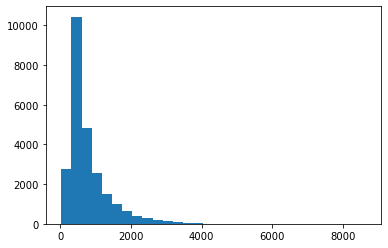

In [101]:
plt.hist(train['review'].apply(len), bins = 30)

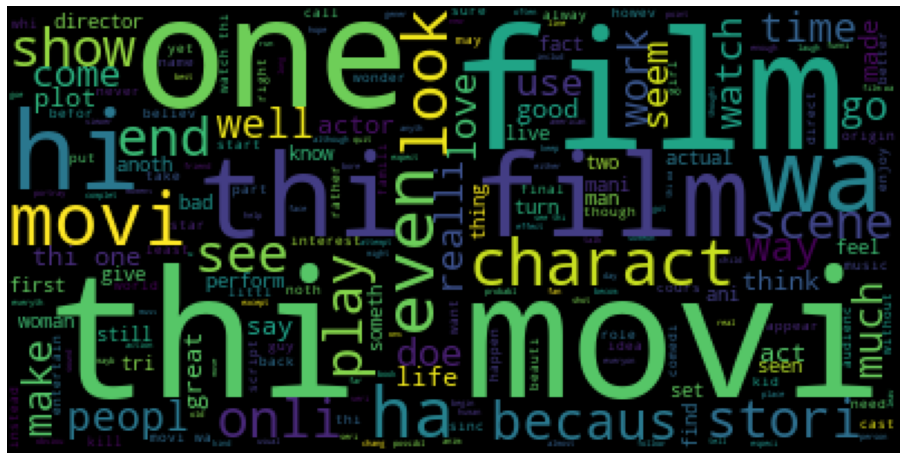

In [102]:
wcloud = ' '.join(train['review'])
wordcloud = WordCloud().generate(wcloud)
plt.figure(figsize = (16, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## TODO

- убрать некторые английские сокращения из-за которых в данные попадают stopwords (done)

In [103]:
from sklearn.model_selection import train_test_split

test = test.sample(frac=1).reset_index(drop=True)
train['class'] = train['class'] == 'pos'
test['class'] = test['class'] == 'pos'

In [104]:
X_train, y_train, X_test, y_test= train['review'], train['class'], test['review'], test['class']

## Baseline

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline

model = LogisticRegression(penalty='l1', solver='saga')

pipeline = Pipeline(steps=[
    ('vector', vectorizer),
    ('model', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2))),
                ('model', LogisticRegression(penalty='l1', solver='saga'))])

In [106]:
conf_score = pipeline.predict_proba(X_test)
preds= pipeline.predict(X_test)
print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.9163010784000001
F1 0.8370627166719193


In [108]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold()

params = {
#     'model__C' : [1e-2, 1e-1, 1e1, 1e3]
    'model__C' : [10]
}

clf = GridSearchCV(pipeline, cv=cv, param_grid=params)
clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_features=500,
                                                        ngram_range=(1, 2))),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           solver='saga'))]),
             param_grid={'model__C': [10]})

In [109]:
print(clf.best_params_)
conf_score = clf.predict_proba(X_test)
preds = clf.predict(X_test)


{'model__C': 10}


In [110]:
print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds)) 

ROC-AUC 0.9159358016000001
F1 0.8361251580278128


<AxesSubplot:xlabel='weight', ylabel='feature'>

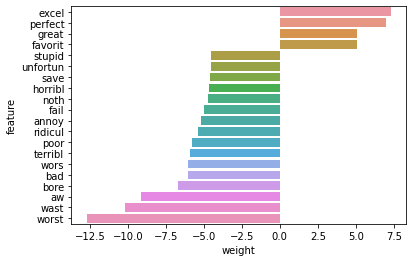

In [111]:
import eli5
feature_importance = eli5.explain_weights_df(clf.estimator[1], top=20, feature_names=clf.estimator[0].get_feature_names())
sns.barplot(x="weight", y="feature", data=feature_importance)

## SGD Classifier

In [112]:
model = SGDClassifier(loss='log')
pipeline = Pipeline(steps=[
    ('vector', vectorizer),
    ('model', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2))),
                ('model', SGDClassifier(loss='log'))])

In [114]:
preds = pipeline.predict(X_test)
conf_score=pipeline.predict_proba(X_test)
print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.9154753664000002
F1 0.8365672819056633


In [115]:
params = {'model__alpha' : [1e-5, 1e-3, 1e-1, 1e1, 1e3],
         'model__max_iter': range(1000, 5000, 1000)}

clf = GridSearchCV(pipeline, cv=cv, param_grid=params)
clf.fit(X_train, y_train)
clf.best_params_

{'model__alpha': 1e-05, 'model__max_iter': 1000}

In [116]:
conf_score = clf.predict_proba(X_test)
preds = clf.predict(X_test)


print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.9159050624
F1 0.8387843258253627


<AxesSubplot:xlabel='weight', ylabel='feature'>

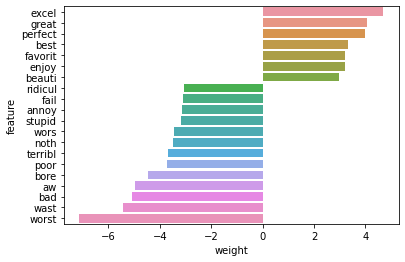

In [117]:
feature_importance = eli5.explain_weights_df(clf.estimator[1], top=20, feature_names=clf.estimator[0].get_feature_names())
sns.barplot(x="weight", y="feature", data=feature_importance)

## Linear SVC

In [118]:
model = LinearSVC()
pipeline = Pipeline(steps=[
    ('vector', vectorizer),
    ('model', model)
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print('ROC-AUC', roc_auc_score(y_test, preds))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.8347199999999999
F1 0.8371818110174166


<AxesSubplot:xlabel='weight', ylabel='feature'>

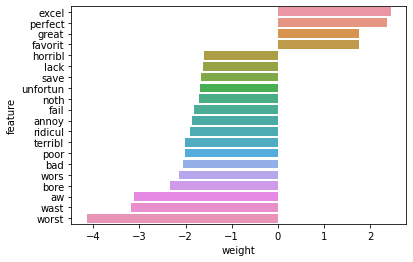

In [119]:
feature_importance = eli5.explain_weights_df(pipeline[1], top=20, feature_names=pipeline[0].get_feature_names())
sns.barplot(x="weight", y="feature", data=feature_importance)

## Naive Bayes

In [120]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()
pipeline = Pipeline(steps=[
    ('vector', vectorizer),
    ('model', model)
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
conf_score=pipeline.predict_proba(X_test)
print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.8865758784
F1 0.8117564730580826


In [122]:
params = {
    'model__alpha': [1e-2, 1e-1, 1e1, 1e-2]
}

clf = GridSearchCV(pipeline, cv=cv, param_grid=params)
clf.fit(X_train, y_train)
clf.best_params_

{'model__alpha': 0.1}

In [124]:
conf_score = clf.predict_proba(X_test)
preds = clf.predict(X_test)


print('ROC-AUC', roc_auc_score(y_test, conf_score.flatten()[1::2]))
print('F1', f1_score(y_test, preds))

ROC-AUC 0.8865902783999999
F1 0.8116640746500778


In [129]:
feature_importance = eli5.explain_weights_df(clf.estimator[1], top=20, feature_names=clf.estimator[0].get_feature_names())


In [139]:
coef = pd.DataFrame(clf.estimator[1].coef_.reshape(-1, 1), index=clf.estimator[0].get_feature_names())

<AxesSubplot:>

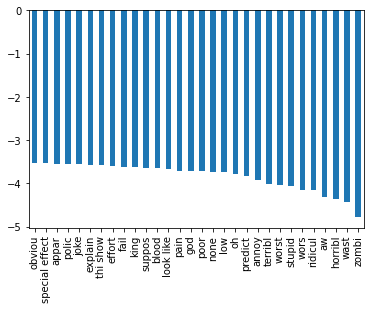

In [151]:
coef['abs'] = abs(coef[0])
coef.sort_values(by='abs').tail(30)[0].plot.bar()

## Выводы

- Все модели показывают примерно одинаковый результат
- На смысловую нагрузку текста больше всего влияют прилагательные
- Наилучший результат на тестовой выборке показала модель SVM (Linear SVC)